**Part 3 - Mapping Closure in 2D for f_BZ using layers**

This notebook implements the mapping closure developed by (Chen, H. 1989) and extended by (Pope, S.B. 1991) for a two-dimensional (2D) problem where the vector of random variables $\bm{Y} = (B,Z)$ includes the buoyancy $B$ and the vertical height $Z$. Distinct however from (Pope, S.B. 1991) we will only treat $B$ using the mapping closure.


*Evolution equation*

The joint pdf $f_{\bm{Y}}$ evolves according to the forward Kolmogorov equation given by

\begin{equation}
\frac{\partial f_{\bm{Y}} }{ \partial t}= -\frac{\partial }{\partial y_i} \bm{D}^{(1)}_i f_{\bm{Y}}  + \frac{\partial^{2}}{\partial y_i \partial y_j} \bm{D}^{(2)}_{ij} f_{\bm{Y}},
\end{equation}

which is given explicitly by

\begin{equation}
    \frac{\partial f_{\bm{Y}} }{\partial t} = - \frac{\partial }{\partial b} \bm{D}^{(1)}_1 f_{\bm{Y}}  - \frac{\partial }{\partial z} \mathbb{E}_{\bm{Y}}[W] f_{\bm{Y}} - \alpha \frac{\partial^2 }{\partial b^2} \left( \mathbb{E}_{\bm{Y}}[ |\nabla B|^2] f_{\bm{Y}} \right) + \alpha \frac{\partial^2 }{\partial z^2} f_{\bm{Y}}.
\end{equation}

To extend the 1D mapping case to treat the $Z$ variable we adopt the notation of (Pope, S. 2000) and by only considering the case when $f_Z(z)=1$ (i.e. a uniform distribution) we write $f_{B}(b;z,t) = f_{\bm{Y}}(b,z;t)/f_Z(z)$. We then define the modified mapping $\mathscr{Y}(-,z,t):\mathbb{R}\rightarrow \mathbb{R}$ be such that
\begin{equation}
  F_{B}(\mathscr{Y}(\eta,z,t); z,t) = G(\eta),
\end{equation}
where $G$ is the cumulative Gaussian distribution, which upon taking $f_B = \partial_b F_B$ implies that
\begin{equation}
  f_{B}(\mathscr{Y}; z,t)=g(\eta)\left(\frac{\partial \mathscr{Y}}{\partial \eta}\right)^{-1},
\end{equation}
for the cumulative distribution $F_{B}$ of process $B$ and the Gaussian distribution $g$. 


As this definition corresponds to applying the mapping closure to statistically homogeneous horizontal slices, we must split the gradient into its horizontal and vertical components. Applying the mapping to a horizontal slice gives
\begin{equation}
  \mathbb{E}_{\bm{Y}}[|\nabla_H B|^{2}]= -\frac{1}{\tau_{Y}(t)}\left( \frac{\partial \mathscr{Y}}{\partial \eta} \right)^{2}.
\end{equation}
For the vertical gradient however we need a further assumption. One option is to relate the horizontal and vertical gradients as
\begin{equation}
  \mathbb{E}_{\bm{Y}}[|\nabla_Z B|^{2}]= -\frac{\lambda(z)}{\tau_{Y}(t)}\left( \frac{\partial \mathscr{Y}}{\partial \eta} \right)^{2},
\end{equation}
via the parameter $\lambda$ which characterises the ratio of the vertical and horizontal Taylor microscales. 


Using the chain rule, the density $f_{B}:=\partial_{b}F_{B}$ evolves according to
\begin{equation}
  \frac{\partial f_{B}}{\partial t} + \frac{\partial }{\partial b}\left( \frac{\partial \mathscr{Y}}{\partial t} f_{B} \right)=0.
\end{equation}
Setting $\mathbb{E}_{\bm{Y}}[W] = 0$ as this term requires an additional closure and the forcing $\bm{D}^{(1)}_1 = 0$ for now, we substitute these expressions in for the time derivative and gradient. We can then write the Fokker-Planck equation as 
\begin{equation}
    \frac{\partial }{\partial b}\left( \frac{\partial \mathscr{Y}}{\partial t} f_{B} \right) = \frac{\alpha(1 + \lambda(z))}{\tau_{Y}(t)} \frac{\partial^2 }{\partial b^2} \left( \left( \frac{\partial \mathscr{Y}}{\partial \eta} \right)^{2} f_B \right) - \alpha \frac{\partial^2 f_B}{\partial z^2}.
\end{equation}
Integrating this equation with respect to $b$, dividing through by $f_B$ and simplifying the conditional diffusion term we can re-write the previous equation as
\begin{equation}
    \frac{\partial \mathscr{Y} }{\partial t} = \frac{\alpha( 1 + \lambda(z))}{\tau_Y(t)} \left( -\eta \frac{\partial \mathscr{Y}}{\partial \eta} + \frac{\partial^2 \mathscr{Y}}{\partial \eta^2} \right) - \frac{1}{f_B}\int_0^{b=\mathscr{Y}} \frac{\partial^2 f_{B}}{\partial z^2} \;  db.
\end{equation}

Finally by using the total derivative
\begin{equation}
\frac{d f_B}{d z} = \frac{\partial f_B}{\partial z} + \frac{\partial }{\partial b} \left( f_B \frac{\partial \mathscr{Y}}{\partial z} \right) = 0
\end{equation}
and expressing $f_B = g(\eta) \left( \frac{\partial \mathscr{Y} }{\partial \eta} \right)^{-1}$ we write the previous equation as
\begin{equation}
    \frac{\partial \mathscr{Y} }{\partial t} = \frac{\alpha( 1 + \lambda(z))}{\tau_Y(t)} \left( -\eta \frac{\partial \mathscr{Y}}{\partial \eta} + \frac{\partial^2 \mathscr{Y}}{\partial \eta^2} \right) + \frac{\partial^2 \mathscr{Y} }{\partial z^2} - \frac{\partial^2 \mathscr{Y} }{\partial \eta \partial z} \left( \frac{\partial \mathscr{Y} }{\partial z} /\frac{\partial \mathscr{Y} }{\partial \eta} \right).
\end{equation}

Below we implement this equation using finite differences by specifying $f_{B}(b;z=0,t)$ and $f_{B}(b;z=1,t)$ as a normal distribution with mean $\mu_0 = 1, \mu_1 = -1$ respectively and variance $\Sigma = 1/2$ in both cases. 

**Setup**

We first import the required libraries to implement this model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.integrate import cumulative_trapezoid 
from scipy.special import erf

We then define a computation grid for $f_{B}(b;z,t)$ in terms of $b,z$.

In [18]:
# Boundary conditions
bc_b = 'Neumann'
bc_z = 'Neumann'

# Numerical resolution
N_b = 32
N_z = 16

# Domain
b = np.linspace(-4, 4, N_b)
z = np.linspace(0, 1, N_z) 

Subsequently for the mapping equation we define a computational grid $\eta$ on which the Gaussian random variables is defined. 

In [19]:
# Time scales (cf. Taylor microscale)
t1 = 1

# Boundary conditions
bc_η = 'Neumann'

# Domain
η =  np.linspace(-4, 4, N_b) #copy.deepcopy(b)  # b = Y(η,z,t)
#z = np.linspace(0, 1, N2)  # z

When defining the functions $\mathscr{Y}^n(\eta,z) = \mathscr{Y}(\eta,z, t=t_n)$ and $f^n_B(b;z) = f_B(b;z,t=t_n)$ we use 2 dimensional arrays where axis 0 is $b/\eta$ and the axis 1 is $z$.

*Differential operators*

To define the differential operators in the equations right hand sides we first define the gradient and Laplacian operators:

In [20]:
# Define the gradient & Laplacian operators
def grad(x):
  """Gradient operator ∂/∂x"""
  N = len(x)
  dx= x[1] - x[0] 
  D = np.zeros((N,N))
  for i in range(N):
    if i < N-1:
      D[i,i+1] = 1
    if i > 0:
      D[i,i-1] =-1
  return D/(2*dx)

def laplacian(x, bcs = 'Dirichlet'):
  """Laplacian ∂^2/∂x^2"""
  
  N = len(x)
  dx= x[1] - x[0] 

  L = np.zeros((N,N))
  for i in range(N):

    L[i,i] = -2.
    if i ==N-1:
      if bcs == 'Dirichlet':
        L[i,i-1] = 1
      elif bcs == 'Neumann':
        L[i,i-1] = 2
    elif i == 0:
      if bcs == 'Dirichlet':
        L[i,i+1] = 1
      elif bcs == 'Neumann':
        L[i,i+1] = 2
    else:
      L[i,i-1] = 1
      L[i,i+1] = 1

  return L/(dx**2)

def test_derivatives():
  """Check the derivatives are correctly implemented"""
  
  x = np.linspace(0, 2*np.pi, 256)
  
  D = grad(x)
  error_D = ( np.cos(x)[1:-1] - D.dot(np.sin(x))[1:-1])**2
  assert np.trapz(y=error_D,x=x[1:-1]) < 1e-07

  L = laplacian(x)
  error_L = (-np.sin(x)[1:-1] - L.dot(np.sin(x))[1:-1])**2
  assert np.trapz(y=error_L,x=x[1:-1]) < 1e-07

  return None

test_derivatives()

Then we define the Gaussian reference fields

In [21]:
def G(η):
    """Cumulative Gaussian distribution."""
    return (1+erf(η/np.sqrt(2)))/2

def g(η):
    """Gaussian distribution."""
    return np.exp(-η**2/2)/np.sqrt(2*np.pi)

Finally we specify the boundary conditions for the joint pdf as
\begin{equation}
f_{B|Z=z_i} = \frac{1}{\Sigma \sqrt{2 \pi} } \exp\left( -\frac{1}{2} \left( \frac{b - \mu_i}{\Sigma} \right)^2 \right)
\end{equation}
with $\mu_0 = 1$ and the bottom boundary ($z=0$) and $\mu_0=-1$ and the top boundary ($z=1$). The corresponding boundary conditions for the mapping are given by
\begin{equation}
\mathscr{Y}(\eta,z_i,t) = \mu_i + \Sigma \eta.
\end{equation}

In [22]:
μ_0 =  1
μ_1 = -1
Σ   = .5

def BC_PDF(b, z):
    
    if   z == 0:
        return np.exp(-.5*( (b - μ_0)/Σ)**2 )/(Σ*np.sqrt(2*np.pi))
    elif z == 1:
        return np.exp(-.5*( (b - μ_1)/Σ)**2 )/(Σ*np.sqrt(2*np.pi))
    else:
        return None

def BC_CDF(b, z):
    
    if   z == 0:
        return .5*( 1 + erf( (b - μ_0)/(np.sqrt(2)*Σ) ) )
    elif z == 1:
        return .5*( 1 + erf( (b - μ_1)/(np.sqrt(2)*Σ) ) )
    else:
        return None
    
def BC_MAP(η, z):
    
    if   z == 0:
        return μ_0 + Σ*η
    elif z == 1:
        return μ_1 + Σ*η
    else:
        return None

Using these operators we construct implicit and explicit time stepping schemes for the mapping equation.

In [23]:
def diffusionZ_CDF(Y, η, z):
  
  Δz = z[1]-z[0]

  # a) Compute f_ηZ
  I_z = np.eye(len(z))
  D_η = np.kron(grad(η),I_z)
  
  g_η = np.kron(g(η),np.ones(len(z)))
  dY_dη = D_η@Y
  f = (g_η/(dY_dη)).reshape((len(η),len(z)))
  Y = Y.reshape((len(η),len(z)))

  # b) Compute F from f
  F = 0*f
  for j,z_j in enumerate(z):
    F[:,j] = cumulative_trapezoid(y=f[:,j], x=Y[:,j], initial=0)

  # c) Differentiate whilst applying bcs
  ddF = 0*F
  for j,z_j in enumerate(z):
    if j == 1:
      F_bc = BC_CDF(b=Y[:,j-1],z=0)
      ddF[:,j] = (F[:,j+1] - 2*F[:,j] + F_bc    )/Δz**2
    elif j == len(z)-2:
      F_bc = BC_CDF(b=Y[:,j+1],z=1)
      ddF[:,j] = (F_bc     - 2*F[:,j] + F[:,j-1])/Δz**2
    elif j > 1 and j < len(z)-2:
      ddF[:,j] = (F[:,j+1] - 2*F[:,j] + F[:,j-1])/Δz**2
  
  return -ddF.flatten()/f.flatten()


def operators_EXP(η, z, τ=1, α=1, λ=1):

  I_z = np.eye(len(z))
  I_η = np.eye(len(η))

  D_η = np.kron(grad(η),I_z)
  D_z = np.kron(I_η,grad(z))

  L_z = np.kron(I_η, laplacian(z,bcs=bc_z)) 
  L_η = np.kron(laplacian(η,bcs=bc_η),I_z)

  H   = np.kron(np.diag(η),I_z)
  L   = (α*(1 + λ)/τ)*( L_η - (H@D_η) ) +  α*L_z
  
  return L, D_η, D_z

def solve_EXP(Y, L, D_η, D_z, Δt):

  # a) Compute diffusion from Z
  diffZ = ( (D_z@Y)/(D_η@Y) )*( D_z@(D_η@Y) ) 

  # b) Update the mapping 
  return Y + Δt*(L@Y + diffZ)


def operators_IMP(η, z, Δt, τ=1, α=1, λ=1):

  I_z = np.eye(len(z))
  I_η = np.eye(len(η))

  D_η = np.kron(grad(η),I_z)
  D_z = np.kron(I_η,grad(z))

  L_z = np.kron(I_η, laplacian(z,bcs=bc_z)) 
  L_η = np.kron(laplacian(η,bcs=bc_η),I_z)

  H   = np.kron(np.diag(η),I_z)
  L   = (α*(1 + λ)/τ)*( L_η - (H@D_η) ) +  α*L_z

  II = np.kron(I_η, I_z)
  A  = (II/Δt - L/2) 
  B  = (II/Δt + L/2)

  return A, B, D_η, D_z

def solve_IMP(Y, A, B, D_η, D_z):

  # a) Compute diffusion from Z
  diffZ = ( (D_z@Y)/(D_η@Y) )*( D_z@(D_η@Y) ) 

  # b) Update the mapping 
  return np.linalg.solve(A, B@Y + diffZ)

We then write helper functions to recover the density from the mapping and to enforce the boundary conditions.

In [24]:
def map_to_density(Y,η,z,b):

  # a) Compute f_ηZ
  I_z = np.eye(len(z))
  D_η = np.kron(grad(η),I_z)
  
  g_η = np.kron(g(η),np.ones(len(z)))
  dY_dη = D_η@Y
  f_ηz = (g_η/(dY_dη))

  #b) reshape
  f_ηz = f_ηz.reshape((len(η),len(z)))
  Y = Y.reshape((len(η),len(z)))

  # b) Interpolate to get f_BZ
  f_bz = np.zeros((len(b),len(z)))
  for i,z_i in enumerate(z):
    if i == 0:
      f_bz[:, i] = BC_PDF(b, z=0)
    elif i == len(z) - 1:
      f_bz[:, i] = BC_PDF(b, z=1)
    else:
      f_bz[:, i] = np.interp(x=b, xp=Y[:,i], fp=f_ηz[:,i], left=0, right=0) 

  return f_bz

def enforce_bc(Y,η,z):

  Y = Y.reshape((len(η),len(z)))
  Y[:, 0] = BC_MAP(η,z=0)
  Y[:,-1] = BC_MAP(η,z=1)
  return Y.flatten()

def solver(f,Y,η,b,z,T, Δt):

  N_z = len(z)

  f_frames = []
  f_frames.append(f)

  Y_frames = []
  Y_frames.append(Y)

  A, B, D_η, D_z = operators_IMP(η, z, Δt)
  L,    D_η, D_z = operators_EXP(η, z)

  # Loop over all time instants
  for n,t in enumerate(T):
  
    # 0) Plot the system out
    if n%(len(T)//10) == 0:
      print('t = %3.3f \n' % t)
      
      fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, layout='constrained')
      ax1.set_title(r'$f$')
      cf = ax1.pcolormesh(b,z,f.reshape((len(b),N_z)).T, cmap='Reds')#, norm='log')
      fig.colorbar(cf, ax=ax1)
      ax1.set_xlabel('$b$')
      ax1.set_ylabel('$z$')

      ax2.set_title(r'$\mathscr{Y}$')
      cf = ax2.pcolormesh(η,z,Y.reshape((len(η),N_z)).T, cmap='Reds')#, norm='log')
      fig.colorbar(cf, ax=ax2)
      ax2.set_xlabel('$\eta$')
      ax2.set_ylabel('$z$')
      plt.show()

    # 1) Update the mapping
    Y = enforce_bc(Y,η,z)
    #Y = solve_IMP(Y, A, B, D_η, D_z)
    Y = solve_EXP(Y, L, D_η, D_z, Δt)

    # 2) Grab the density
    f = map_to_density(Y,η,z,b)

    # 3) Grab the system state
    f_frames.append(f)
    Y_frames.append(Y)

  return None

Finally we specify a time interval, initial conditions and time-step the system

t = 0.000 



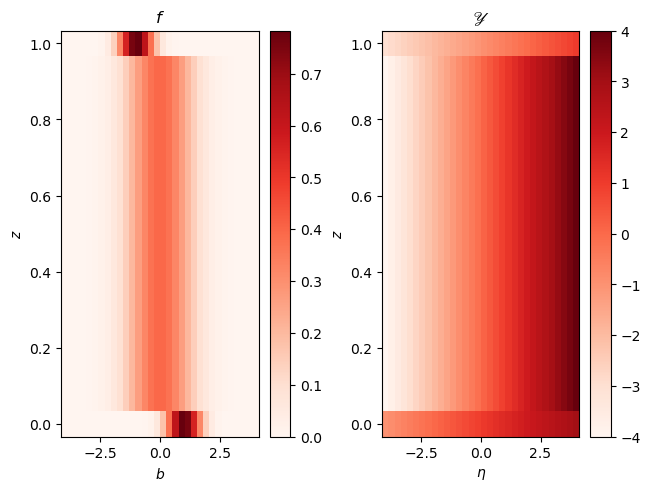

t = 0.010 



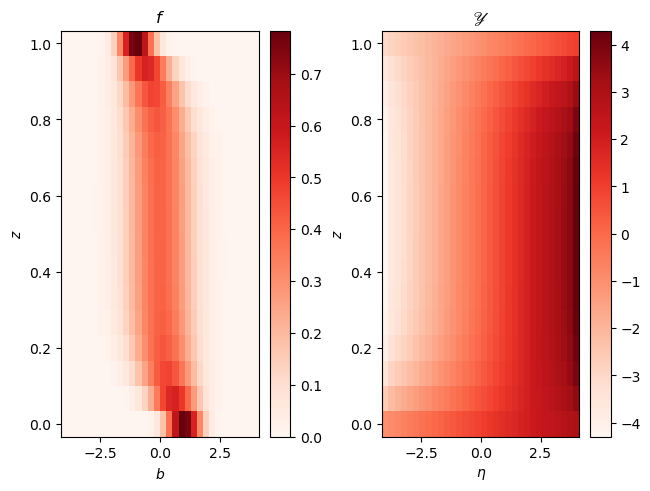

t = 0.020 



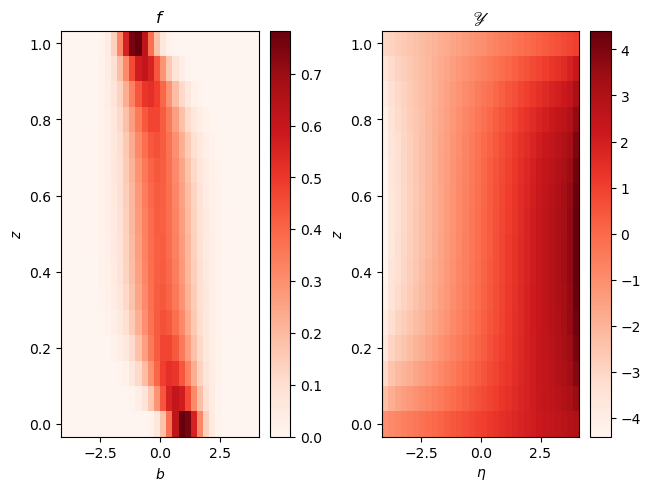

t = 0.030 



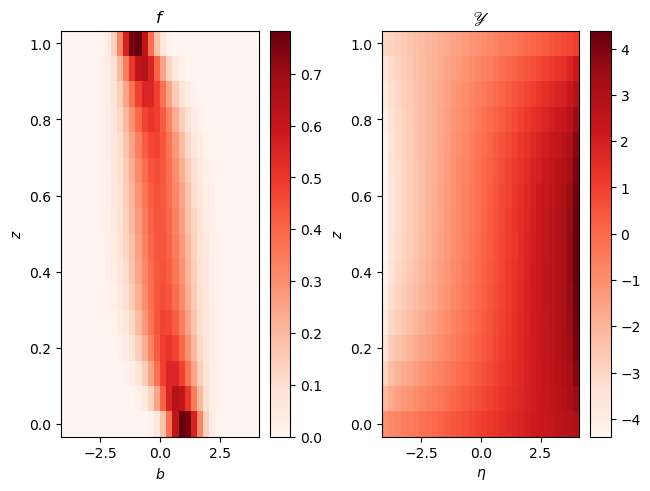

t = 0.040 



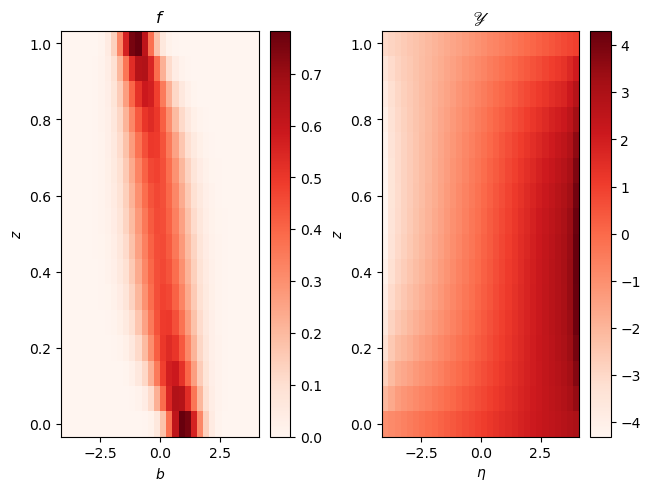

t = 0.050 



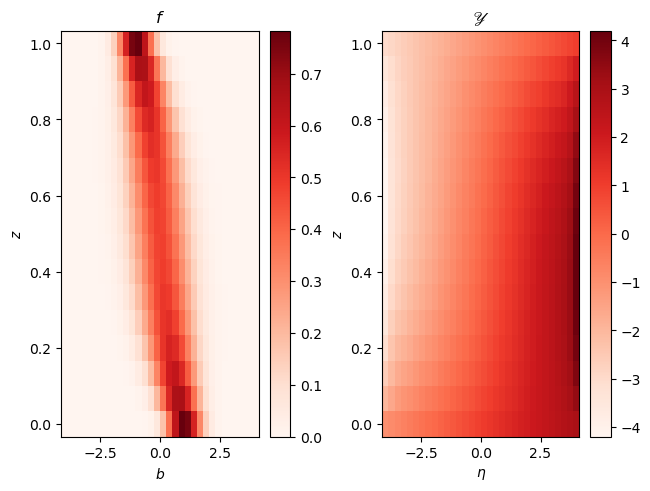

t = 0.060 



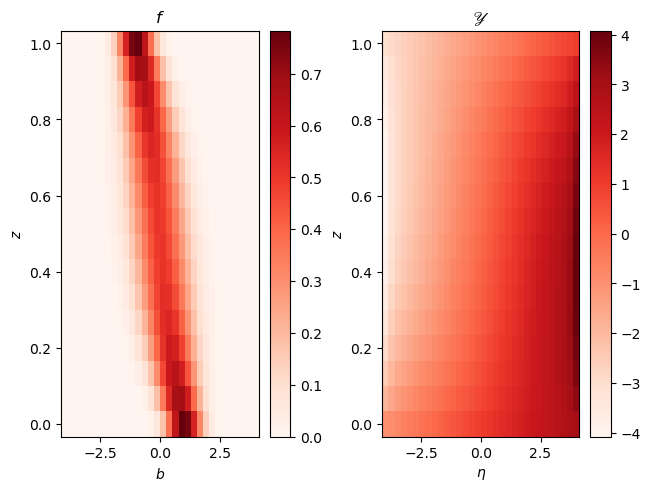

t = 0.070 



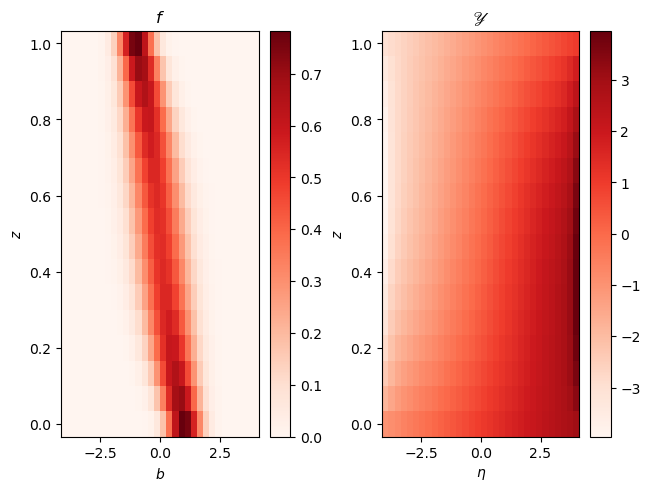

t = 0.080 



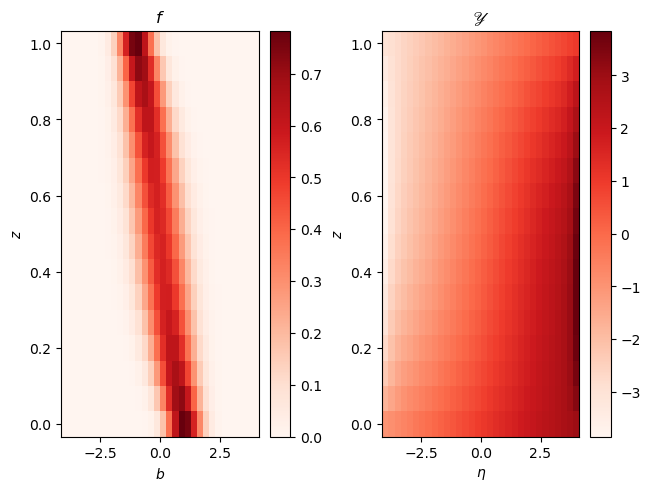

t = 0.090 



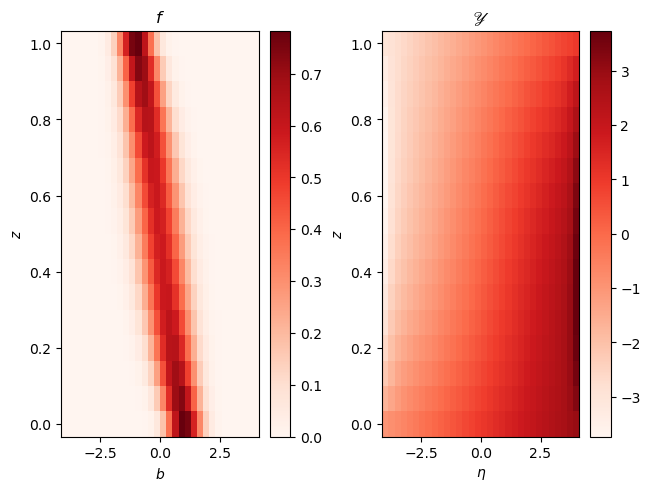

In [25]:
N_T = 2*(10**4)
T, Δt = np.linspace(0,.1,N_T,retstep=True)

# Initial conditions for f shape b, z
f = np.zeros((len(b),len(z)))
for i,z_i in enumerate(z):
    if i == 0:
        f[:,i] = BC_PDF(b,z=0)
    elif i == len(z)-1:
        f[:,i] = BC_PDF(b,z=1)
    else:
        f[:,i] = g(b)

# Initial conditions for mapping X shape η, z
Y = np.zeros((len(η),len(z)))
for i,z_i in enumerate(z):
    if i == 0:
        Y[:,i] = BC_MAP(η,z=0)
    elif i == len(z)-1:
        Y[:,i] = BC_MAP(η,z=1)
    else:
        Y[:,i] = η

# Flatten the inputs and pass them to the solver and check with reshape
Y = Y.flatten()
f = f.flatten()

solver(f,Y,η,b,z,T, Δt)